# Performance Of Various Asset Classes During Fed Policy Cycles

## Python Imports

In [1]:
# Standard Library
import datetime
import io
import os
import random
import sys
import warnings

from datetime import datetime, timedelta
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, MultipleLocator

# Data Sources
import yfinance as yf
import pandas_datareader.data as web

# Statistical Analysis
import statsmodels.api as sm

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

## Add Directories To Path

In [2]:
# Add the source subdirectory to the system path to allow import config from settings.py
current_directory = Path(os.getcwd())
website_base_directory = current_directory.parent.parent.parent
src_directory = website_base_directory / "src"
sys.path.append(str(src_directory)) if str(src_directory) not in sys.path else None

# Import settings.py
from settings import config

# Add configured directories from config to path
SOURCE_DIR = config("SOURCE_DIR")
sys.path.append(str(Path(SOURCE_DIR))) if str(Path(SOURCE_DIR)) not in sys.path else None

# Add other configured directories
BASE_DIR = config("BASE_DIR")
CONTENT_DIR = config("CONTENT_DIR")
POSTS_DIR = config("POSTS_DIR")
PAGES_DIR = config("PAGES_DIR")
PUBLIC_DIR = config("PUBLIC_DIR")
SOURCE_DIR = config("SOURCE_DIR")
DATA_DIR = config("DATA_DIR")
DATA_MANUAL_DIR = config("DATA_MANUAL_DIR")

# Print system path
for i, path in enumerate(sys.path):
    print(f"{i}: {path}")

0: /usr/lib/python313.zip
1: /usr/lib/python3.13
2: /usr/lib/python3.13/lib-dynload
3: 
4: /home/jared/python-virtual-envs/general_313/lib/python3.13/site-packages
5: /home/jared/python-virtual-envs/general_313/lib/python3.13/site-packages/setuptools/_vendor
6: /home/jared/Cloud_Storage/Dropbox/Websites/jaredszajkowski.github.io/src


## Track Index Dependencies

In [3]:
# Create file to track markdown dependencies
dep_file = Path("index_dep.txt")
dep_file.write_text("")

0

## Python Functions

In [4]:
from calc_fed_cycle_asset_performance import calc_fed_cycle_asset_performance
from df_info import df_info
from df_info_markdown import df_info_markdown
from export_track_md_deps import export_track_md_deps
from load_data import load_data
from pandas_set_decimal_places import pandas_set_decimal_places
from plot_bar_returns_ffr_change import plot_bar_returns_ffr_change
from plot_timeseries import plot_timeseries
from plot_scatter_regression_ffr_vs_returns import plot_scatter_regression_ffr_vs_returns
from sm_ols_summary_markdown import sm_ols_summary_markdown
from summary_stats import summary_stats
from yf_pull_data import yf_pull_data

## Data Overview

In [5]:
# Set timeframe
start_date = "2004-11-30"  # GLD inception (month end)
end_date = "2025-10-31"

### Acquire & Plot Fed Funds Data

In [6]:
# Set decimal places
pandas_set_decimal_places(4)

# Pull Effective Fed Funds Rate from FRED
fedfunds = web.DataReader("FEDFUNDS", "fred", start="1900-01-01", end=datetime.today())
fedfunds["FEDFUNDS"] = fedfunds["FEDFUNDS"] / 100  # Convert to decimal

# Resample to monthly frequency and compute change in rate
fedfunds_monthly = fedfunds.resample("M").last()
fedfunds_monthly = fedfunds_monthly[(fedfunds_monthly.index >= pd.to_datetime(start_date)) & (fedfunds_monthly.index <= pd.to_datetime(end_date))]
fedfunds_monthly["FedFunds_Change"] = fedfunds_monthly["FEDFUNDS"].diff()

In [7]:
df_info(fedfunds_monthly)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2004-11-30 to 2025-10-31
Freq: ME
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FEDFUNDS         252 non-null    float64
 1   FedFunds_Change  251 non-null    float64
dtypes: float64(2)
memory usage: 5.9 KB
None
The first 5 rows are:


,FEDFUNDS,FedFunds_Change
DATE,,
2004-11-30,0.0193,NaN
2004-12-31,0.0216,0.0023
2005-01-31,0.0228,0.0012
2005-02-28,0.0250,0.0022
2005-03-31,0.0263,0.0013


The last 5 rows are:


,FEDFUNDS,FedFunds_Change
DATE,,
2025-06-30,0.0433,0.0000
2025-07-31,0.0433,0.0000
2025-08-31,0.0433,0.0000
2025-09-30,0.0422,-0.0011
2025-10-31,0.0409,-0.0013


In [8]:
# Copy this <!-- INSERT_01_Fed_Funds_Monthly_Rate_Change_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="01_Fed_Funds_Monthly_Rate_Change.md", content=df_info_markdown(df=fedfunds_monthly, decimal_places=4))

✅ Exported and tracked: 01_Fed_Funds_Monthly_Rate_Change.md


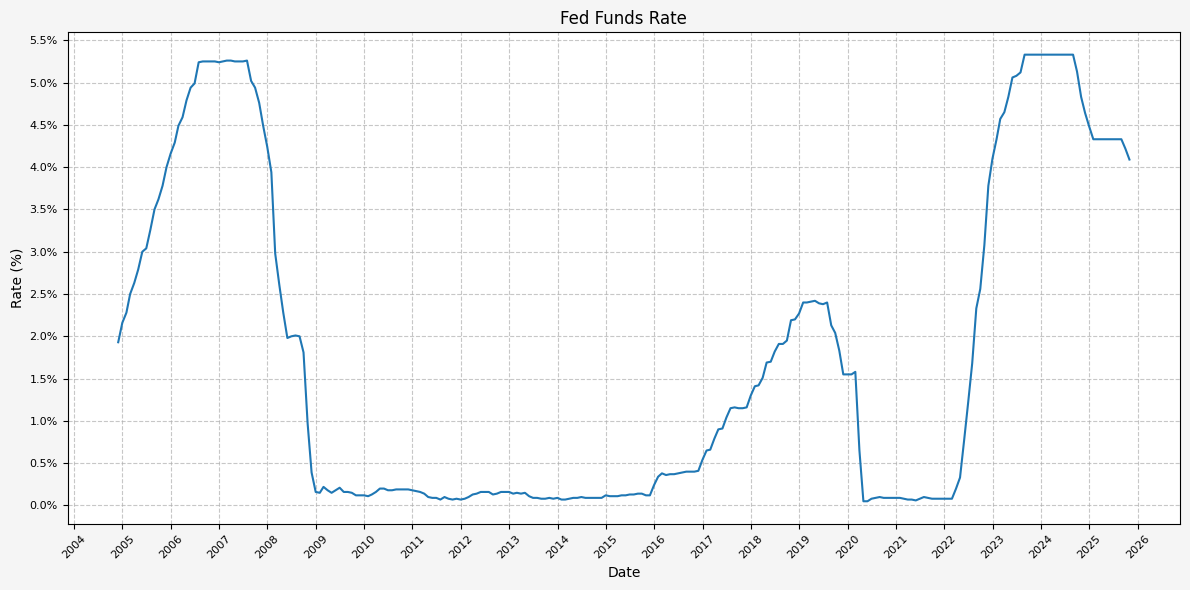

In [9]:
plot_timeseries(
    price_df=fedfunds_monthly,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["FEDFUNDS"],
    title="Fed Funds Rate",
    x_label="Date",
    x_format="Year",
    y_label="Rate (%)",
    y_format="Percentage",
    y_format_decimal_places=1,
    y_tick_spacing=0.005,
    grid=True,
    legend=False,
    export_plot=True,
    plot_file_name="01_Fed_Funds_Rate",
)

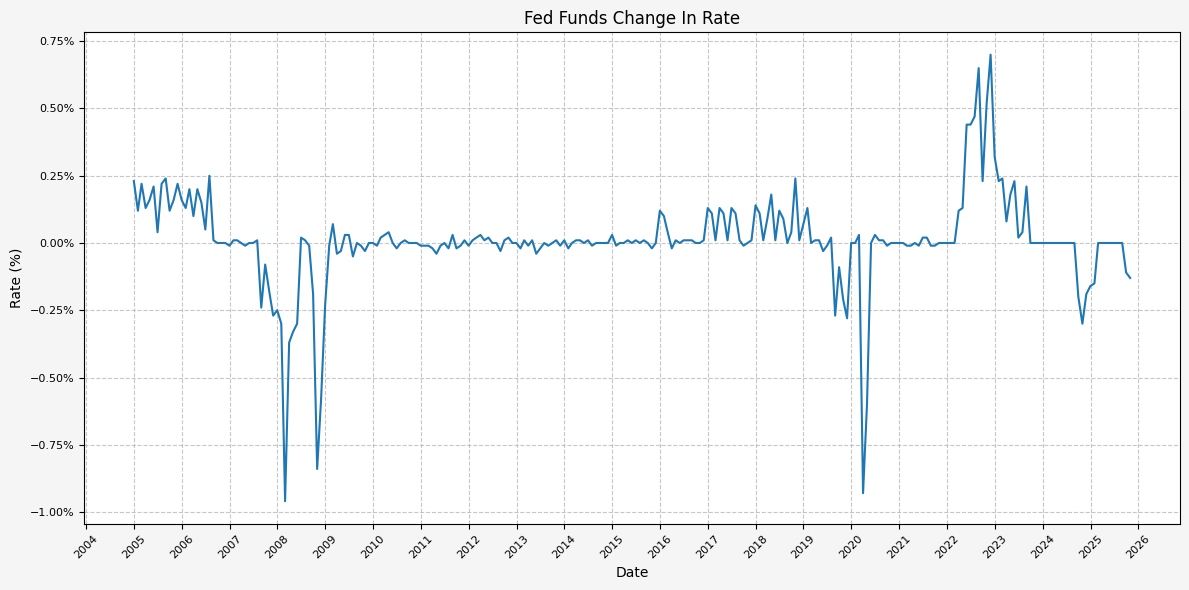

In [10]:
plot_timeseries(
    price_df=fedfunds_monthly,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["FedFunds_Change"],
    title="Fed Funds Change In Rate",
    x_label="Date",
    x_format="Year",
    y_label="Rate (%)",
    y_format="Percentage",
    y_format_decimal_places=2,
    y_tick_spacing=0.0025,
    grid=True,
    legend=False,
    export_plot=True,
    plot_file_name="01_Fed_Funds_Change_In_Rate",
)

### Define Fed Policy Cycles

In [11]:
# # Define manually specified Fed policy cycles
# fed_cycles = [
#     # ("2002-01-01", "2003-07-01"),
#     # ("2003-07-01", "2004-06-01"),
#     # ("2004-06-01", "2006-07-01"),
#     ("2004-11-01", "2006-07-01"),
#     ("2006-07-01", "2007-07-01"),
#     ("2007-07-01", "2008-12-01"),
#     ("2008-12-01", "2015-11-01"),
#     ("2015-11-01", "2019-01-01"),
#     ("2019-01-01", "2019-07-01"),
#     ("2019-07-01", "2020-04-01"),
#     ("2020-04-01", "2022-02-01"),
#     ("2022-02-01", "2023-08-01"),
#     ("2023-08-01", "2024-08-01"),
#     ("2024-08-01", datetime.today().strftime('%Y-%m-%d')),
# ]

# # Optional: assign a name to each cycle
# cycle_labels = [f"Cycle {i+1}" for i in range(len(fed_cycles))]

In [12]:
# Define manually specified Fed policy cycles
fed_cycles = [
    ("2004-11-01", "2006-07-01"),
    ("2006-07-01", "2007-07-01"),
    ("2007-07-01", "2008-12-01"),
    ("2008-12-01", "2015-11-01"),
    ("2015-11-01", "2019-01-01"),
    ("2019-01-01", "2019-07-01"),
    ("2019-07-01", "2020-04-01"),
    ("2020-04-01", "2022-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2023-08-01", "2024-08-01"),
    ("2024-08-01", datetime.today().strftime('%Y-%m-%d')),
]

# Optional: assign a name to each cycle
cycle_labels = [f"Cycle {i+1}" for i in range(len(fed_cycles))]

In [13]:
# Set decimal places
pandas_set_decimal_places(4)

#  Calc changes by fed cycle defined above
fed_changes = []

for (start, end) in fed_cycles:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    try:
        rate_start = fedfunds.loc[start, "FEDFUNDS"]
    except KeyError:
        rate_start = fedfunds.loc[:start].iloc[-1]["FEDFUNDS"]

    try:
        rate_end = fedfunds.loc[end, "FEDFUNDS"]
    except KeyError:
        rate_end = fedfunds.loc[:end].iloc[-1]["FEDFUNDS"]

    change = rate_end - rate_start
    fed_changes.append(change)

fed_changes_df = pd.DataFrame({
    "Cycle": cycle_labels,
    "FedFunds_Change": fed_changes
})

fed_changes_df

,Cycle,FedFunds_Change
0,Cycle 1,0.0331
1,Cycle 2,0.0002
2,Cycle 3,-0.0510
3,Cycle 4,-0.0004
4,Cycle 5,0.0228
5,Cycle 6,0.0000
6,Cycle 7,-0.0235
7,Cycle 8,0.0003
8,Cycle 9,0.0525
9,Cycle 10,0.0000


In [14]:
# Copy this <!-- INSERT_01_Fed_Funds_Cycle_Change_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="01_Fed_Funds_Cycle_Change.md", content=fed_changes_df.to_markdown(floatfmt=".4f"))

✅ Exported and tracked: 01_Fed_Funds_Cycle_Change.md


## Return Performance By Fed Policy Cycle

### Stocks (SPY)

In [15]:
# Set decimal places
pandas_set_decimal_places(2)

yf_pull_data(
    base_directory=DATA_DIR,
    ticker="SPY",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds", 
    excel_export=True,
    pickle_export=True,
    output_confirmation=True,
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

The first and last date of data for SPY is: 


,Close,High,Low,Open,Volume
Date,,,,,
1993-01-29,24.31,24.33,24.21,24.33,1003200


,Close,High,Low,Open,Volume
Date,,,,,
2025-11-26,679.68,681.70,676.72,677.63,71879600


Yahoo Finance data complete for SPY
--------------------


,Close,High,Low,Open,Volume
Date,,,,,
1993-01-29,24.31,24.33,24.21,24.33,1003200
1993-02-01,24.49,24.49,24.33,24.33,480500
1993-02-02,24.54,24.56,24.42,24.47,201300
1993-02-03,24.80,24.81,24.56,24.57,529400
1993-02-04,24.90,24.95,24.61,24.88,531500
...,...,...,...,...,...
2025-11-20,652.53,675.56,651.89,672.91,165293500
2025-11-21,659.03,664.55,650.85,655.05,123956200
2025-11-24,668.73,670.06,661.59,662.69,80437900


In [16]:
spy = load_data(
    base_directory=DATA_DIR,
    ticker="SPY",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds",
    timeframe="Daily",
    file_format="pickle",
)

# Filter SPY to date range
spy = spy[(spy.index >= pd.to_datetime(start_date)) & (spy.index <= pd.to_datetime(end_date))]

# Resample to monthly frequency
spy_monthly = spy.resample("M").last()
spy_monthly["Monthly_Return"] = spy_monthly["Close"].pct_change()

In [17]:
df_info(spy_monthly)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2004-11-30 to 2025-10-31
Freq: ME
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           252 non-null    float64
 1   High            252 non-null    float64
 2   Low             252 non-null    float64
 3   Open            252 non-null    float64
 4   Volume          252 non-null    int64  
 5   Monthly_Return  251 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None
The first 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2004-11-30,79.83,80.07,79.66,79.90,53685200,NaN
2004-12-31,82.23,82.77,82.19,82.53,28648800,0.03
2005-01-31,80.39,80.45,80.08,80.25,52532700,-0.02
2005-02-28,82.07,82.53,81.67,82.43,69381300,0.02
2005-03-31,80.57,80.91,80.51,80.73,64575400,-0.02


The last 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2025-06-30,616.14,617.51,613.34,615.67,92502500,0.05
2025-07-31,630.33,638.08,629.03,637.69,103385200,0.02
2025-08-31,643.27,646.05,641.36,645.68,74522200,0.02
2025-09-30,666.18,666.65,661.61,662.93,86288000,0.04
2025-10-31,682.06,685.08,679.24,685.04,87164100,0.02


In [18]:
# Copy this <!-- INSERT_02_SPY_Monthly_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="02_SPY_Monthly.md", content=df_info_markdown(df=spy_monthly, decimal_places=2))

✅ Exported and tracked: 02_SPY_Monthly.md


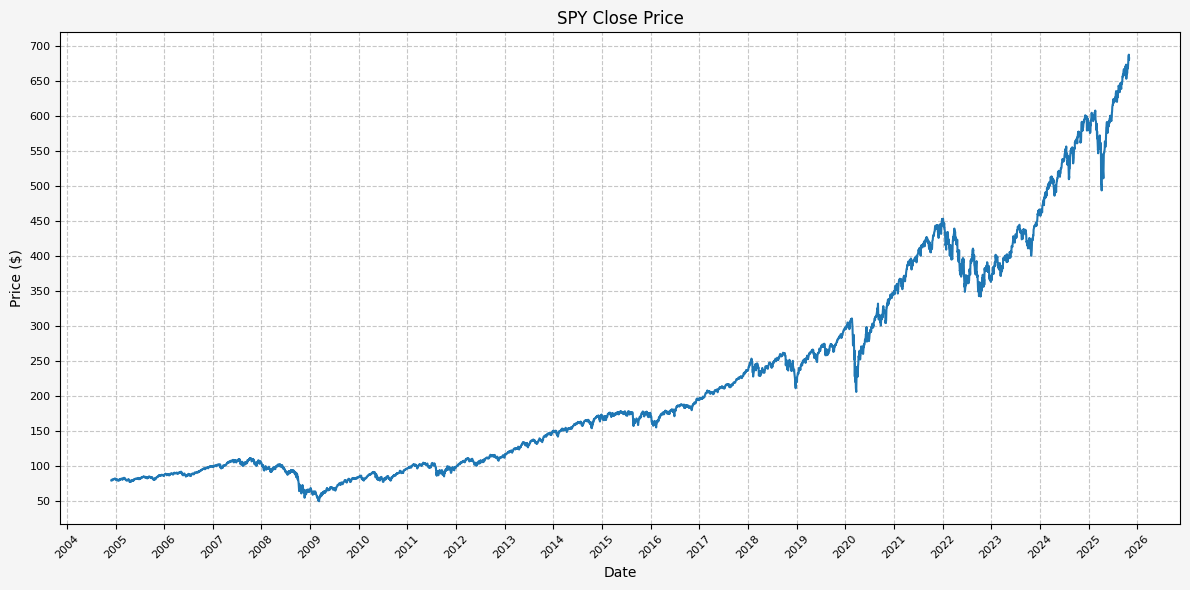

In [19]:
plot_timeseries(
    price_df=spy,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Close"],
    title="SPY Close Price",
    x_label="Date",
    x_format="Year",
    y_label="Price ($)",
    y_format="Decimal",
    y_format_decimal_places=0,
    y_tick_spacing=50,
    grid=True,
    legend=False,
    export_plot=True,
    plot_file_name="02_SPY_Price",
)

In [20]:
spy_cycle_df = calc_fed_cycle_asset_performance(
    fed_cycles=fed_cycles,
    cycle_labels=cycle_labels,
    fed_changes=fed_changes,
    monthly_df=spy_monthly,
)

spy_cycle_df

,Cycle,Start,End,Months,CumulativeReturn,CumulativeReturnPct,AverageMonthlyReturn,AverageMonthlyReturnPct,AnnualizedReturn,AnnualizedReturnPct,Volatility,FedFundsChange,FedFundsChange_bps,FFR_AnnualizedChange,FFR_AnnualizedChange_bps,Label
0,Cycle 1,2004-11-01,2006-07-01,20,0.11,11.32,0.01,0.59,0.07,6.64,0.08,0.03,331.00,0.02,198.60,"Cycle 1, 2004-11-01 to 2006-07-01"
1,Cycle 2,2006-07-01,2007-07-01,12,0.20,20.36,0.02,1.57,0.20,20.36,0.07,0.00,2.00,0.00,2.00,"Cycle 2, 2006-07-01 to 2007-07-01"
2,Cycle 3,2007-07-01,2008-12-01,17,-0.39,-38.55,-0.03,-2.67,-0.29,-29.09,0.19,-0.05,-510.00,-0.04,-360.00,"Cycle 3, 2007-07-01 to 2008-12-01"
3,Cycle 4,2008-12-01,2015-11-01,83,1.67,167.34,0.01,1.28,0.15,15.28,0.15,-0.00,-4.00,-0.00,-0.58,"Cycle 4, 2008-12-01 to 2015-11-01"
4,Cycle 5,2015-11-01,2019-01-01,38,0.28,28.30,0.01,0.70,0.08,8.19,0.11,0.02,228.00,0.01,72.00,"Cycle 5, 2015-11-01 to 2019-01-01"
5,Cycle 6,2019-01-01,2019-07-01,6,0.18,18.33,0.03,2.95,0.40,40.01,0.18,0.00,0.00,0.00,0.00,"Cycle 6, 2019-01-01 to 2019-07-01"
6,Cycle 7,2019-07-01,2020-04-01,9,-0.11,-10.67,-0.01,-1.10,-0.14,-13.96,0.19,-0.02,-235.00,-0.03,-313.33,"Cycle 7, 2019-07-01 to 2020-04-01"
7,Cycle 8,2020-04-01,2022-02-01,22,0.79,79.13,0.03,2.78,0.37,37.43,0.16,0.00,3.00,0.00,1.64,"Cycle 8, 2020-04-01 to 2022-02-01"
8,Cycle 9,2022-02-01,2023-08-01,18,0.04,4.18,0.00,0.40,0.03,2.77,0.21,0.05,525.00,0.03,350.00,"Cycle 9, 2022-02-01 to 2023-08-01"
9,Cycle 10,2023-08-01,2024-08-01,12,0.22,22.00,0.02,1.75,0.22,22.00,0.15,0.00,0.00,0.00,0.00,"Cycle 10, 2023-08-01 to 2024-08-01"


In [21]:
# Copy this <!-- INSERT_02_SPY_Cycle_DF_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="02_SPY_Cycle_DF.md", content=spy_cycle_df.to_markdown(floatfmt=".2f"))

✅ Exported and tracked: 02_SPY_Cycle_DF.md


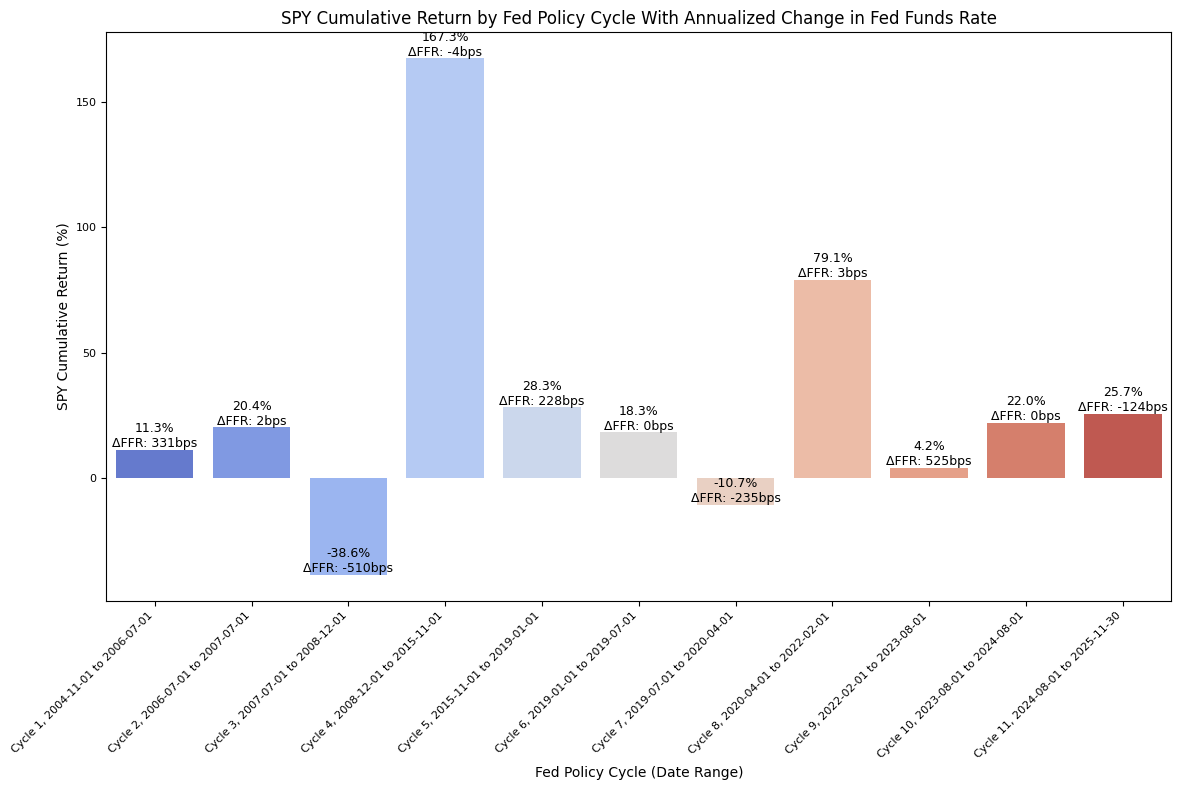

In [22]:
plot_bar_returns_ffr_change(
    cycle_df=spy_cycle_df,
    asset_label="SPY",
    annualized_or_cumulative="Cumulative",
    index_num="02",
)

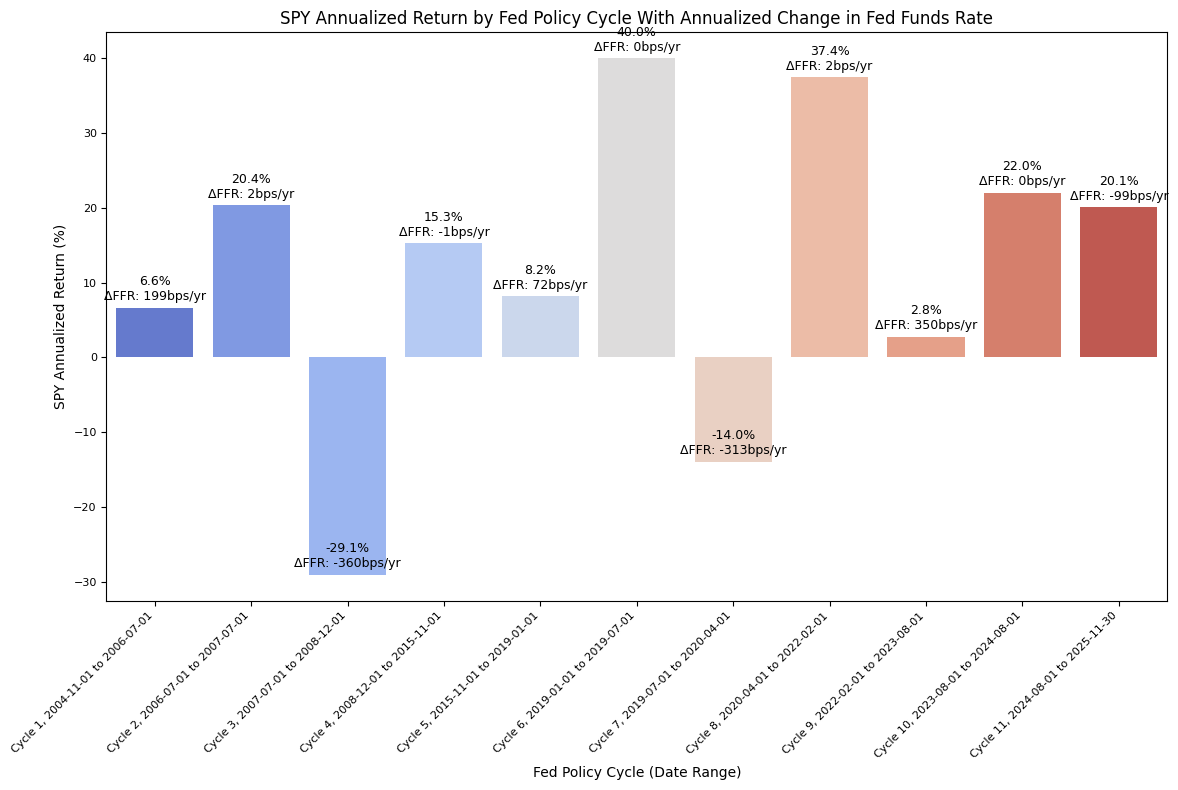

In [23]:
plot_bar_returns_ffr_change(
    cycle_df=spy_cycle_df,
    asset_label="SPY",
    annualized_or_cumulative="Annualized",
    index_num="02",
)

In [24]:
df = spy_cycle_df

####################################
### Don't modify below this line ###
####################################

# Run OLS regression with statsmodels
X = df["FFR_AnnualizedChange_bps"]
y = df["AnnualizedReturnPct"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print(f"Intercept: {model.params[0]}, Slope: {model.params[1]}")  # Intercept and slope

# Calc X and Y values for regression line
X_vals = np.linspace(X.min(), X.max(), 100)
Y_vals = model.params[0] + model.params[1] * X_vals

                             OLS Regression Results                            
Dep. Variable:     AnnualizedReturnPct   R-squared:                       0.184
Model:                             OLS   Adj. R-squared:                  0.093
Method:                  Least Squares   F-statistic:                     2.031
Date:                 Sun, 30 Nov 2025   Prob (F-statistic):              0.188
Time:                         07:50:16   Log-Likelihood:                -47.144
No. Observations:                   11   AIC:                             98.29
Df Residuals:                        9   BIC:                             99.08
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [25]:
# Copy this <!-- INSERT_02_SPY_Annualized_Regression_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="02_SPY_Annualized_Regression.md", content=sm_ols_summary_markdown(result=model, file_path="02_SPY_Annualized_Regression.md"))

✅ Exported and tracked: 02_SPY_Annualized_Regression.md


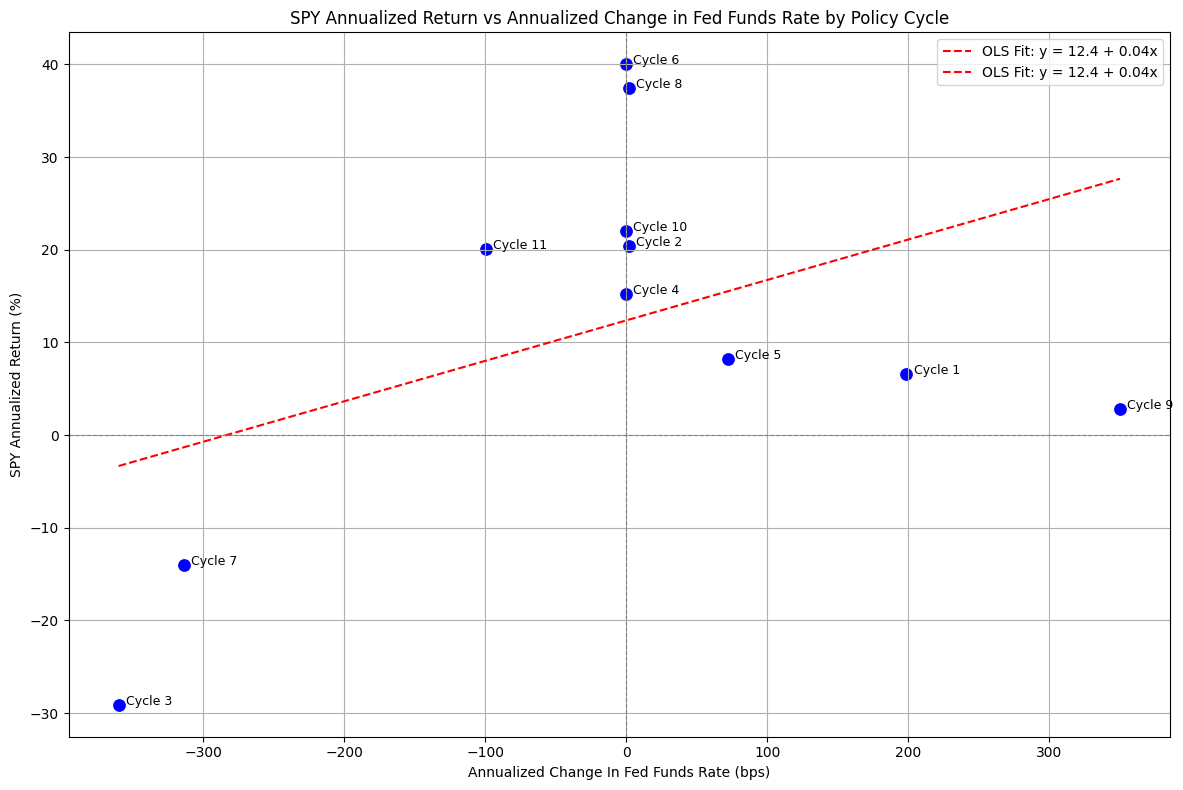

In [26]:
plot_scatter_regression_ffr_vs_returns(
    cycle_df=spy_cycle_df,
    asset_label="SPY",
    index_num="02",
    x_vals=X_vals,
    y_vals=Y_vals,
    intercept=model.params[0],
    slope=model.params[1],
)

### Bonds (TLT)

In [27]:
# Set decimal places
pandas_set_decimal_places(2)

yf_pull_data(
    base_directory=DATA_DIR,
    ticker="TLT",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds", 
    excel_export=True,
    pickle_export=True,
    output_confirmation=True,
)

[*********************100%***********************]  1 of 1 completed

The first and last date of data for TLT is: 


,Close,High,Low,Open,Volume
Date,,,,,
2002-07-30,36.92,37.09,36.92,37.03,6100


,Close,High,Low,Open,Volume
Date,,,,,
2025-11-26,90.64,90.64,89.83,90.15,34099000


Yahoo Finance data complete for TLT
--------------------


,Close,High,Low,Open,Volume
Date,,,,,
2002-07-30,36.92,37.09,36.92,37.03,6100
2002-07-31,37.38,37.50,37.09,37.12,29400
2002-08-01,37.59,37.60,37.38,37.38,25000
2002-08-02,37.98,38.09,37.54,37.67,52800
2002-08-05,38.15,38.24,37.98,38.06,61100
...,...,...,...,...,...
2025-11-20,89.23,89.42,88.99,88.99,32945000
2025-11-21,89.50,89.67,89.20,89.65,41938600
2025-11-24,90.01,90.07,89.78,89.95,30865700


In [28]:
tlt = load_data(
    base_directory=DATA_DIR,
    ticker="TLT",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds",
    timeframe="Daily",
    file_format="pickle",
)

# Filter TLT to date range
tlt = tlt[(tlt.index >= pd.to_datetime(start_date)) & (tlt.index <= pd.to_datetime(end_date))]

# Resample to monthly frequency
tlt_monthly = tlt.resample("M").last()
tlt_monthly["Monthly_Return"] = tlt_monthly["Close"].pct_change()

In [29]:
df_info(tlt_monthly)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2004-11-30 to 2025-10-31
Freq: ME
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           252 non-null    float64
 1   High            252 non-null    float64
 2   Low             252 non-null    float64
 3   Open            252 non-null    float64
 4   Volume          252 non-null    int64  
 5   Monthly_Return  251 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None
The first 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2004-11-30,44.13,44.24,43.97,44.13,1754500,NaN
2004-12-31,45.30,45.35,45.17,45.21,1056400,0.03
2005-01-31,46.92,46.94,46.70,46.72,1313900,0.04
2005-02-28,46.22,46.78,46.16,46.78,2797300,-0.01
2005-03-31,46.01,46.05,45.77,45.95,2410900,-0.00


The last 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2025-06-30,86.64,86.83,86.01,86.26,53695200,0.03
2025-07-31,85.65,86.14,85.57,85.86,49814100,-0.01
2025-08-31,85.66,85.92,85.51,85.82,41686400,0.00
2025-09-30,88.74,89.40,88.58,89.03,38584000,0.04
2025-10-31,89.96,90.33,89.88,90.23,38247300,0.01


In [30]:
# Copy this <!-- INSERT_03_TLT_Monthly_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="03_TLT_Monthly.md", content=df_info_markdown(df=tlt_monthly, decimal_places=2))

✅ Exported and tracked: 03_TLT_Monthly.md


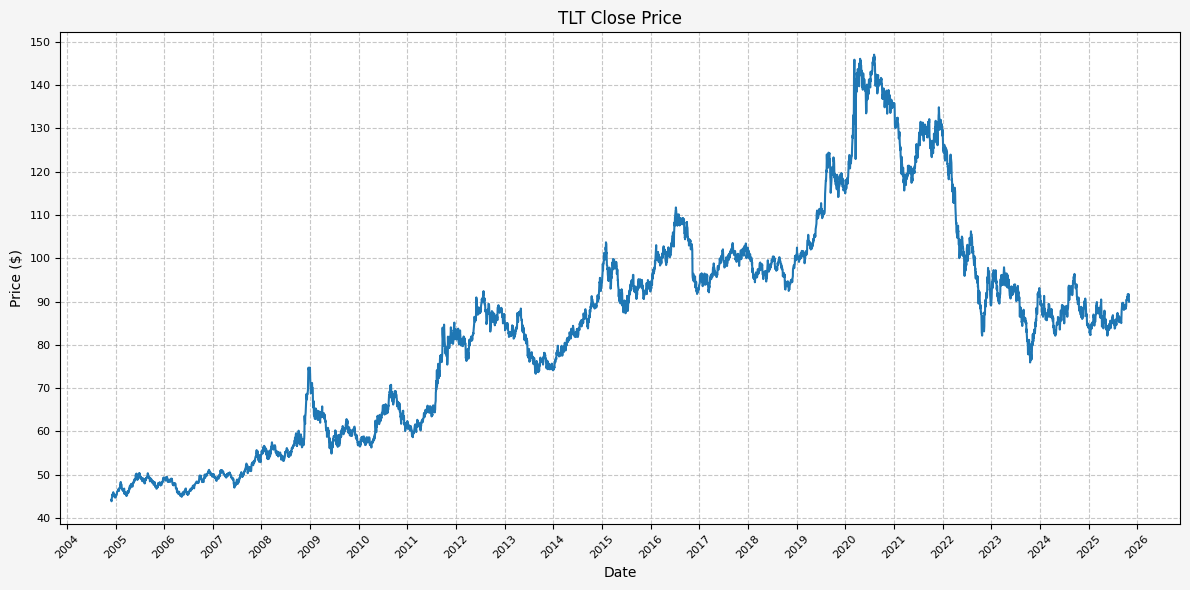

In [31]:
plot_timeseries(
    price_df=tlt,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Close"],
    title="TLT Close Price",
    x_label="Date",
    x_format="Year",
    y_label="Price ($)",
    y_format="Decimal",
    y_format_decimal_places=0,
    y_tick_spacing=10,
    grid=True,
    legend=False,
    export_plot=True,
    plot_file_name="03_TLT_Price",
)

In [32]:
tlt_cycle_df = calc_fed_cycle_asset_performance(
    fed_cycles=fed_cycles,
    cycle_labels=cycle_labels,
    fed_changes=fed_changes,
    monthly_df=tlt_monthly,
)

tlt_cycle_df

,Cycle,Start,End,Months,CumulativeReturn,CumulativeReturnPct,AverageMonthlyReturn,AverageMonthlyReturnPct,AnnualizedReturn,AnnualizedReturnPct,Volatility,FedFundsChange,FedFundsChange_bps,FFR_AnnualizedChange,FFR_AnnualizedChange_bps,Label
0,Cycle 1,2004-11-01,2006-07-01,20,0.04,4.23,0.00,0.25,0.03,2.51,0.09,0.03,331.00,0.02,198.60,"Cycle 1, 2004-11-01 to 2006-07-01"
1,Cycle 2,2006-07-01,2007-07-01,12,0.06,5.76,0.00,0.49,0.06,5.76,0.07,0.00,2.00,0.00,2.00,"Cycle 2, 2006-07-01 to 2007-07-01"
2,Cycle 3,2007-07-01,2008-12-01,17,0.32,32.42,0.02,1.73,0.22,21.92,0.14,-0.05,-510.00,-0.04,-360.00,"Cycle 3, 2007-07-01 to 2008-12-01"
3,Cycle 4,2008-12-01,2015-11-01,83,0.46,45.67,0.01,0.55,0.06,5.59,0.15,-0.00,-4.00,-0.00,-0.58,"Cycle 4, 2008-12-01 to 2015-11-01"
4,Cycle 5,2015-11-01,2019-01-01,38,0.07,7.42,0.00,0.23,0.02,2.29,0.10,0.02,228.00,0.01,72.00,"Cycle 5, 2015-11-01 to 2019-01-01"
5,Cycle 6,2019-01-01,2019-07-01,6,0.10,10.48,0.02,1.73,0.22,22.05,0.13,0.00,0.00,0.00,0.00,"Cycle 6, 2019-01-01 to 2019-07-01"
6,Cycle 7,2019-07-01,2020-04-01,9,0.26,26.18,0.03,2.73,0.36,36.34,0.18,-0.02,-235.00,-0.03,-313.33,"Cycle 7, 2019-07-01 to 2020-04-01"
7,Cycle 8,2020-04-01,2022-02-01,22,-0.11,-11.33,-0.00,-0.50,-0.06,-6.35,0.11,0.00,3.00,0.00,1.64,"Cycle 8, 2020-04-01 to 2022-02-01"
8,Cycle 9,2022-02-01,2023-08-01,18,-0.27,-26.96,-0.02,-1.62,-0.19,-18.90,0.17,0.05,525.00,0.03,350.00,"Cycle 9, 2022-02-01 to 2023-08-01"
9,Cycle 10,2023-08-01,2024-08-01,12,-0.02,-1.52,0.00,0.02,-0.02,-1.52,0.20,0.00,0.00,0.00,0.00,"Cycle 10, 2023-08-01 to 2024-08-01"


In [33]:
# Copy this <!-- INSERT_03_TLT_Cycle_DF_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="03_TLT_Cycle_DF.md", content=tlt_cycle_df.to_markdown(floatfmt=".2f"))

✅ Exported and tracked: 03_TLT_Cycle_DF.md


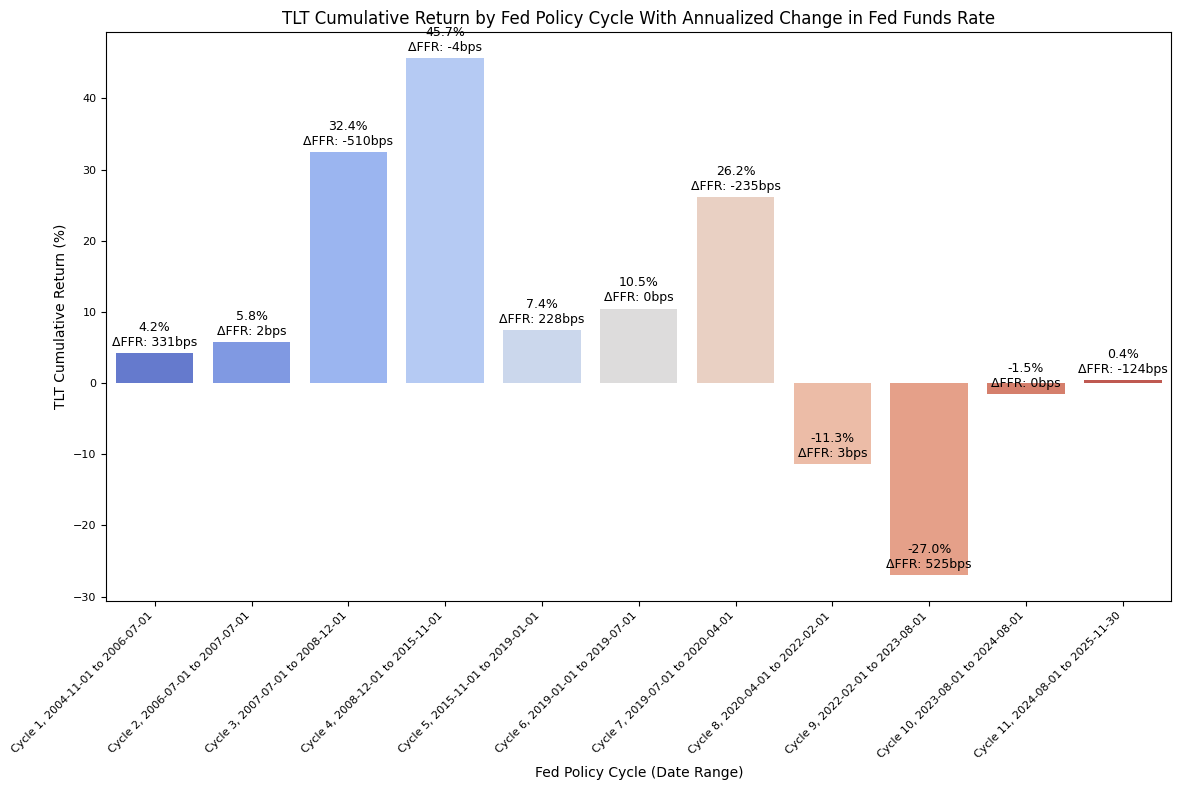

In [34]:
plot_bar_returns_ffr_change(
    cycle_df=tlt_cycle_df,
    asset_label="TLT",
    annualized_or_cumulative="Cumulative",
    index_num="03",
)

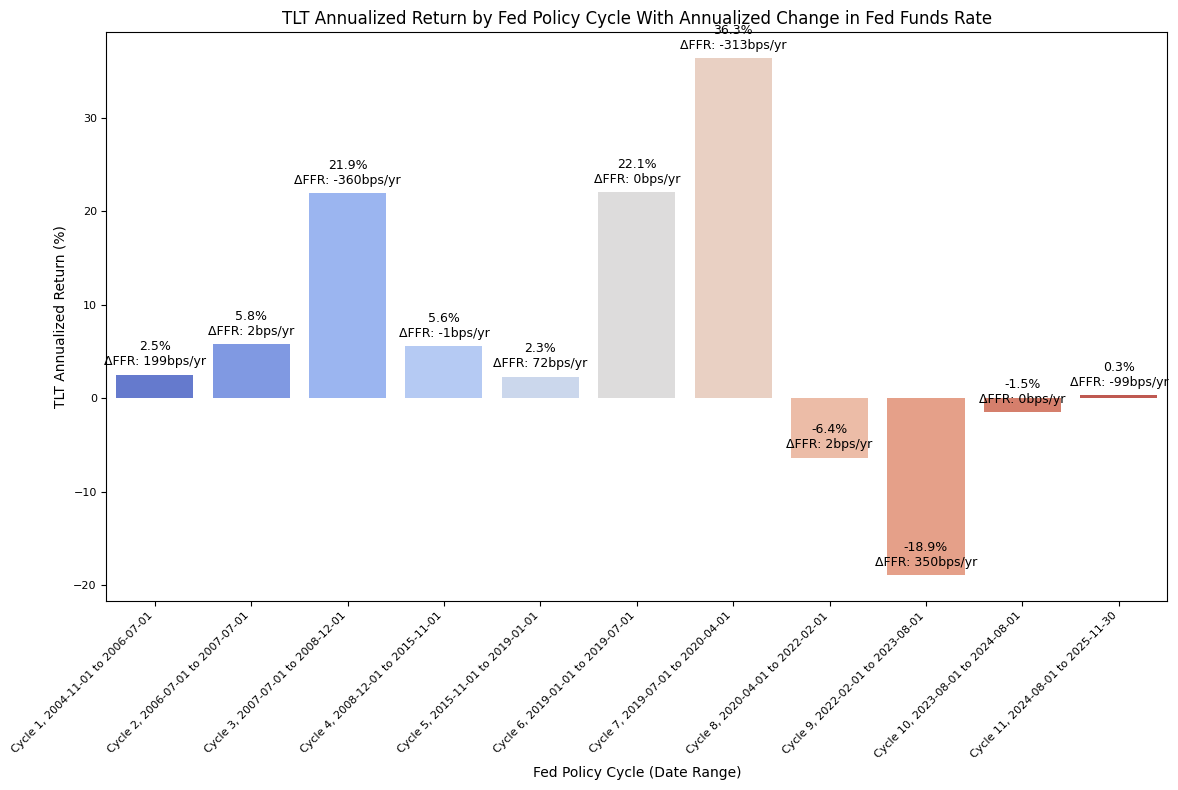

In [35]:
plot_bar_returns_ffr_change(
    cycle_df=tlt_cycle_df,
    asset_label="TLT",
    annualized_or_cumulative="Annualized",
    index_num="03",
)

In [36]:
df = tlt_cycle_df

####################################
### Don't modify below this line ###
####################################

# Run OLS regression with statsmodels
X = df["FFR_AnnualizedChange_bps"]
y = df["AnnualizedReturnPct"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print(f"Intercept: {model.params[0]}, Slope: {model.params[1]}")  # Intercept and slope

# Calc X and Y values for regression line
X_vals = np.linspace(X.min(), X.max(), 100)
Y_vals = model.params[0] + model.params[1] * X_vals

                             OLS Regression Results                            
Dep. Variable:     AnnualizedReturnPct   R-squared:                       0.634
Model:                             OLS   Adj. R-squared:                  0.593
Method:                  Least Squares   F-statistic:                     15.56
Date:                 Sun, 30 Nov 2025   Prob (F-statistic):            0.00338
Time:                         07:50:20   Log-Likelihood:                -39.515
No. Observations:                   11   AIC:                             83.03
Df Residuals:                        9   BIC:                             83.83
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [37]:
# Copy this <!-- INSERT_03_TLT_Annualized_Regression_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="03_TLT_Annualized_Regression.md", content=sm_ols_summary_markdown(result=model, file_path="03_TLT_Annualized_Regression.md"))

✅ Exported and tracked: 03_TLT_Annualized_Regression.md


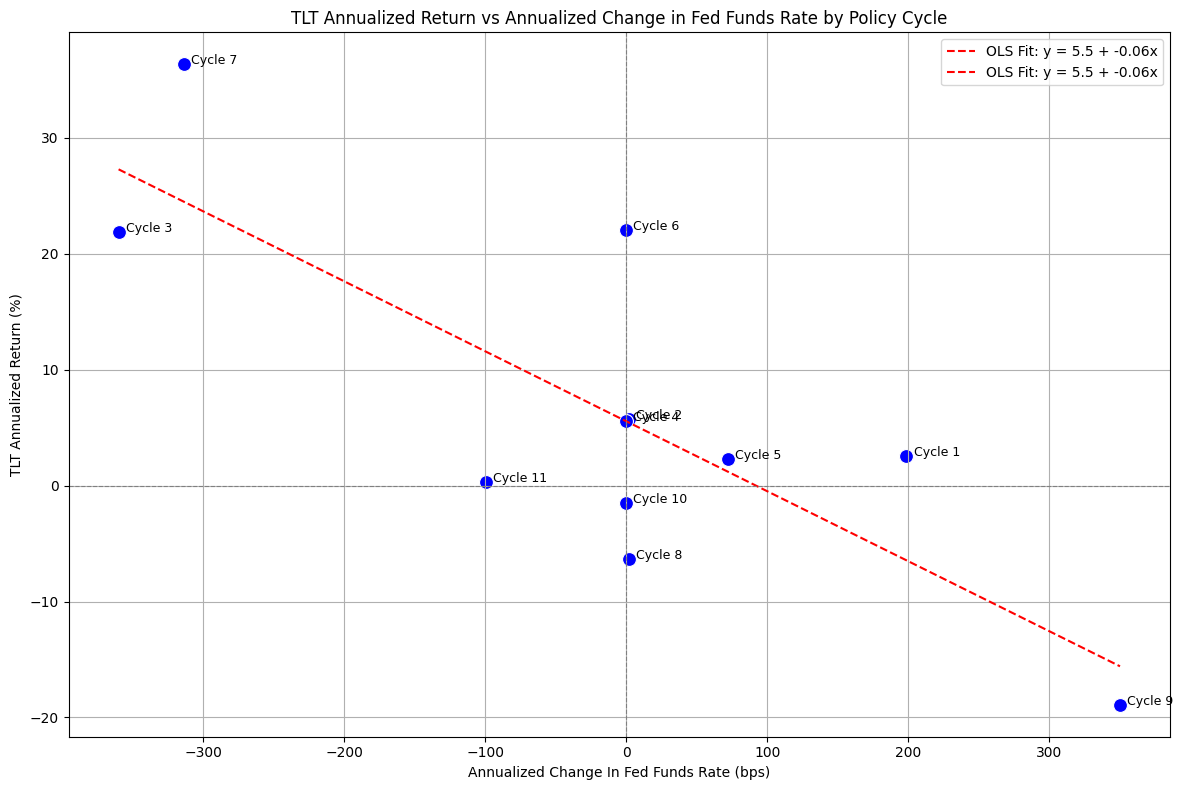

In [38]:
plot_scatter_regression_ffr_vs_returns(
    cycle_df=tlt_cycle_df,
    asset_label="TLT",
    index_num="03",
    x_vals=X_vals,
    y_vals=Y_vals,
    intercept=model.params[0],
    slope=model.params[1],
)

### Gold (GLD)

In [39]:
# Set decimal places
pandas_set_decimal_places(2)

yf_pull_data(
    base_directory=DATA_DIR,
    ticker="GLD",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds", 
    excel_export=True,
    pickle_export=True,
    output_confirmation=True,
)

[*********************100%***********************]  1 of 1 completed

The first and last date of data for GLD is: 


,Close,High,Low,Open,Volume
Date,,,,,
2004-11-18,44.38,44.49,44.07,44.43,5992000


,Close,High,Low,Open,Volume
Date,,,,,
2025-11-26,383.12,383.78,380.46,381.06,9184100


Yahoo Finance data complete for GLD
--------------------


,Close,High,Low,Open,Volume
Date,,,,,
2004-11-18,44.38,44.49,44.07,44.43,5992000
2004-11-19,44.78,44.92,44.47,44.49,11655300
2004-11-22,44.95,44.97,44.74,44.75,11996000
2004-11-23,44.75,44.92,44.72,44.88,3169200
2004-11-24,45.05,45.05,44.79,44.93,6105100
...,...,...,...,...,...
2025-11-20,374.85,377.69,371.85,375.29,10506500
2025-11-21,374.27,377.23,372.94,374.03,13194600
2025-11-24,380.20,380.28,374.19,374.88,10085300


In [40]:
gld = load_data(
    base_directory=DATA_DIR,
    ticker="GLD",
    source="Yahoo_Finance", 
    asset_class="Exchange_Traded_Funds",
    timeframe="Daily",
    file_format="pickle",
)

# Filter GLD to date range
gld = gld[(gld.index >= pd.to_datetime(start_date)) & (gld.index <= pd.to_datetime(end_date))]

# Resample to monthly frequency
gld_monthly = gld.resample("M").last()
gld_monthly["Monthly_Return"] = gld_monthly["Close"].pct_change()

In [41]:
df_info(gld_monthly)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2004-11-30 to 2025-10-31
Freq: ME
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           252 non-null    float64
 1   High            252 non-null    float64
 2   Low             252 non-null    float64
 3   Open            252 non-null    float64
 4   Volume          252 non-null    int64  
 5   Monthly_Return  251 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None
The first 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2004-11-30,45.12,45.41,44.82,45.37,3857200,NaN
2004-12-31,43.80,43.94,43.73,43.85,531600,-0.03
2005-01-31,42.22,42.30,41.96,42.21,1692400,-0.04
2005-02-28,43.53,43.74,43.52,43.68,755300,0.03
2005-03-31,42.82,42.87,42.70,42.87,1363200,-0.02


The last 5 rows are:


,Close,High,Low,Open,Volume,Monthly_Return
Date,,,,,,
2025-06-30,304.83,304.92,301.95,302.39,8192100,0.00
2025-07-31,302.96,304.61,302.86,304.59,8981000,-0.01
2025-08-31,318.07,318.09,314.64,314.72,15642600,0.05
2025-09-30,355.47,355.57,350.87,351.13,13312400,0.12
2025-10-31,368.12,370.66,365.50,370.47,11077900,0.04


In [42]:
# Copy this <!-- INSERT_04_GLD_Monthly_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="04_GLD_Monthly.md", content=df_info_markdown(df=gld_monthly, decimal_places=2))

✅ Exported and tracked: 04_GLD_Monthly.md


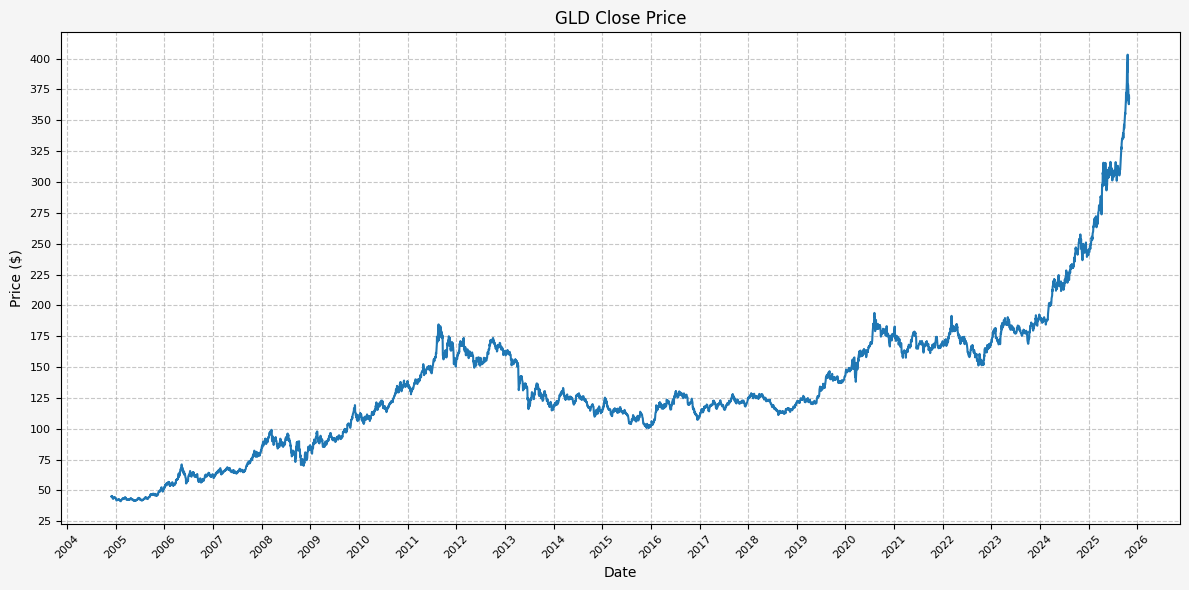

In [43]:
plot_timeseries(
    price_df=gld,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Close"],
    title="GLD Close Price",
    x_label="Date",
    x_format="Year",
    y_label="Price ($)",
    y_format="Decimal",
    y_format_decimal_places=0,
    y_tick_spacing=25,
    grid=True,
    legend=False,
    export_plot=True,
    plot_file_name="04_GLD_Price",
)

In [44]:
gld_cycle_df = calc_fed_cycle_asset_performance(
    fed_cycles=fed_cycles,
    cycle_labels=cycle_labels,
    fed_changes=fed_changes,
    monthly_df=gld_monthly,
)

gld_cycle_df

,Cycle,Start,End,Months,CumulativeReturn,CumulativeReturnPct,AverageMonthlyReturn,AverageMonthlyReturnPct,AnnualizedReturn,AnnualizedReturnPct,Volatility,FedFundsChange,FedFundsChange_bps,FFR_AnnualizedChange,FFR_AnnualizedChange_bps,Label
0,Cycle 1,2004-11-01,2006-07-01,20,0.36,35.70,0.02,1.73,0.20,20.10,0.17,0.03,331.00,0.02,198.60,"Cycle 1, 2004-11-01 to 2006-07-01"
1,Cycle 2,2006-07-01,2007-07-01,12,0.05,4.96,0.00,0.45,0.05,4.96,0.11,0.00,2.00,0.00,2.00,"Cycle 2, 2006-07-01 to 2007-07-01"
2,Cycle 3,2007-07-01,2008-12-01,17,0.25,24.96,0.02,1.59,0.17,17.03,0.26,-0.05,-510.00,-0.04,-360.00,"Cycle 3, 2007-07-01 to 2008-12-01"
3,Cycle 4,2008-12-01,2015-11-01,83,0.36,36.10,0.01,0.51,0.05,4.56,0.18,-0.00,-4.00,-0.00,-0.58,"Cycle 4, 2008-12-01 to 2015-11-01"
4,Cycle 5,2015-11-01,2019-01-01,38,0.11,10.93,0.00,0.35,0.03,3.33,0.14,0.02,228.00,0.01,72.00,"Cycle 5, 2015-11-01 to 2019-01-01"
5,Cycle 6,2019-01-01,2019-07-01,6,0.10,9.86,0.02,1.63,0.21,20.68,0.12,0.00,0.00,0.00,0.00,"Cycle 6, 2019-01-01 to 2019-07-01"
6,Cycle 7,2019-07-01,2020-04-01,9,0.11,11.15,0.01,1.24,0.15,15.13,0.13,-0.02,-235.00,-0.03,-313.33,"Cycle 7, 2019-07-01 to 2020-04-01"
7,Cycle 8,2020-04-01,2022-02-01,22,0.14,13.54,0.01,0.69,0.07,7.17,0.16,0.00,3.00,0.00,1.64,"Cycle 8, 2020-04-01 to 2022-02-01"
8,Cycle 9,2022-02-01,2023-08-01,18,0.08,8.48,0.01,0.53,0.06,5.58,0.14,0.05,525.00,0.03,350.00,"Cycle 9, 2022-02-01 to 2023-08-01"
9,Cycle 10,2023-08-01,2024-08-01,12,0.24,24.24,0.02,1.89,0.24,24.24,0.13,0.00,0.00,0.00,0.00,"Cycle 10, 2023-08-01 to 2024-08-01"


In [45]:
# Copy this <!-- INSERT_04_GLD_Cycle_DF_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="04_GLD_Cycle_DF.md", content=gld_cycle_df.to_markdown(floatfmt=".2f"))

✅ Exported and tracked: 04_GLD_Cycle_DF.md


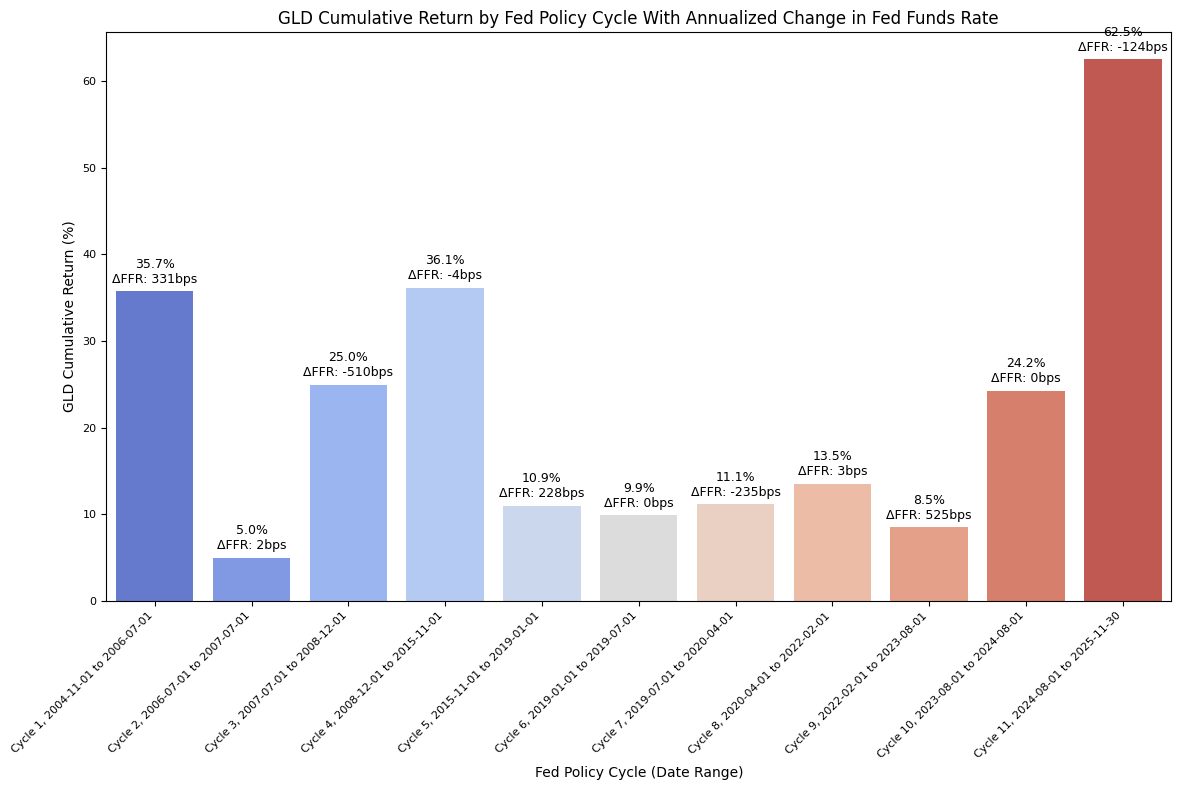

In [46]:
plot_bar_returns_ffr_change(
    cycle_df=gld_cycle_df,
    asset_label="GLD",
    annualized_or_cumulative="Cumulative",
    index_num="04",
)

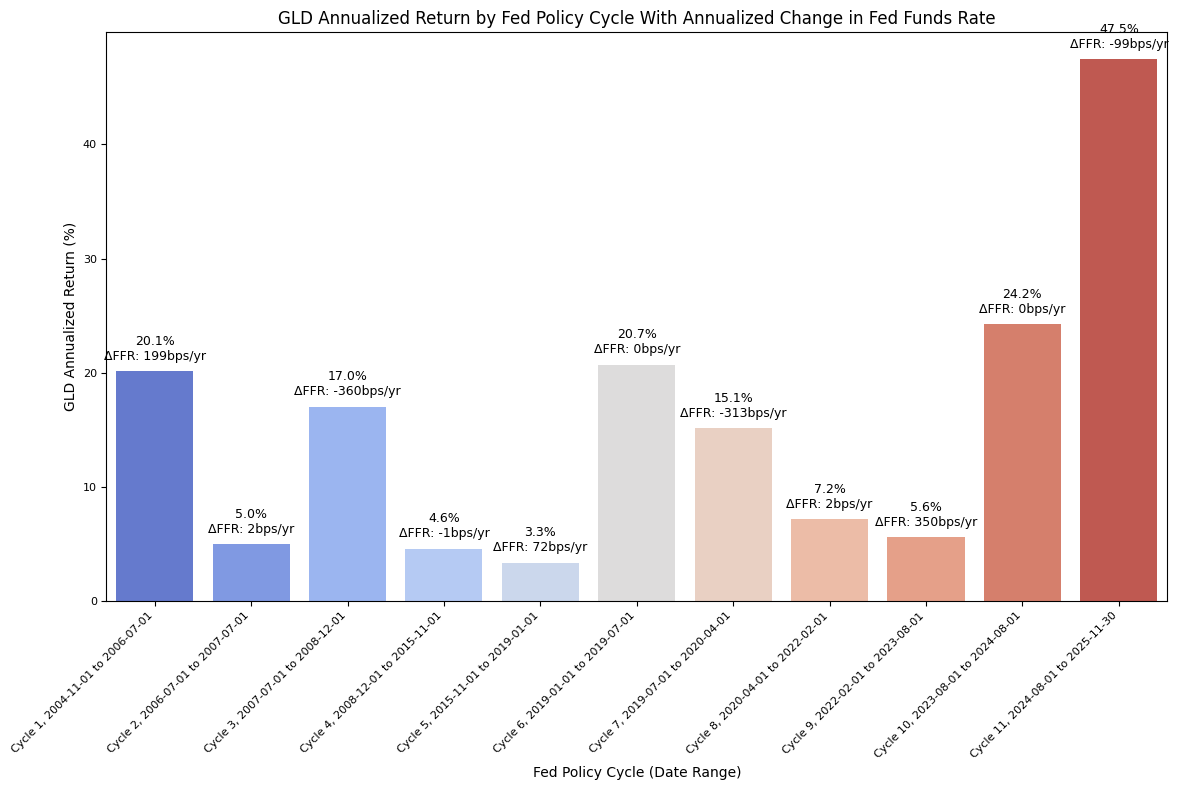

In [47]:
plot_bar_returns_ffr_change(
    cycle_df=gld_cycle_df,
    asset_label="GLD",
    annualized_or_cumulative="Annualized",
    index_num="04",
)

In [48]:
df = gld_cycle_df

####################################
### Don't modify below this line ###
####################################

# Run OLS regression with statsmodels
X = df["FFR_AnnualizedChange_bps"]
y = df["AnnualizedReturnPct"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
print(f"Intercept: {model.params[0]}, Slope: {model.params[1]}")  # Intercept and slope

# Calc X and Y values for regression line
X_vals = np.linspace(X.min(), X.max(), 100)
Y_vals = model.params[0] + model.params[1] * X_vals

                             OLS Regression Results                            
Dep. Variable:     AnnualizedReturnPct   R-squared:                       0.073
Model:                             OLS   Adj. R-squared:                 -0.030
Method:                  Least Squares   F-statistic:                    0.7118
Date:                 Sun, 30 Nov 2025   Prob (F-statistic):              0.421
Time:                         07:50:25   Log-Likelihood:                -42.895
No. Observations:                   11   AIC:                             89.79
Df Residuals:                        9   BIC:                             90.59
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [49]:
# Copy this <!-- INSERT_04_GLD_Annualized_Regression_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="04_GLD_Annualized_Regression.md", content=sm_ols_summary_markdown(result=model, file_path="04_GLD_Annualized_Regression.md"))

✅ Exported and tracked: 04_GLD_Annualized_Regression.md


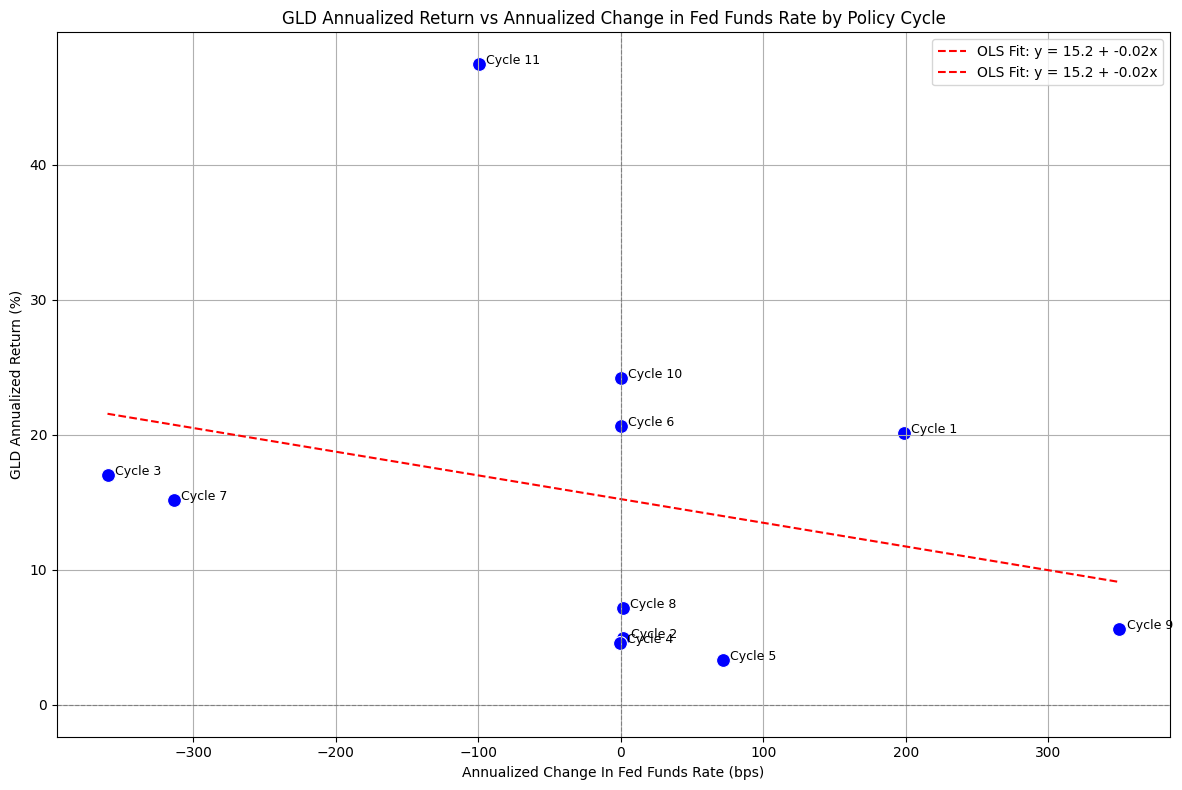

In [50]:
plot_scatter_regression_ffr_vs_returns(
    cycle_df=gld_cycle_df,
    asset_label="GLD",
    index_num="04",
    x_vals=X_vals,
    y_vals=Y_vals,
    intercept=model.params[0],
    slope=model.params[1],
)

## Hybrid Portfolio

### Asset Allocation

In [51]:
fed_cycles

[('2004-11-01', '2006-07-01'),
 ('2006-07-01', '2007-07-01'),
 ('2007-07-01', '2008-12-01'),
 ('2008-12-01', '2015-11-01'),
 ('2015-11-01', '2019-01-01'),
 ('2019-01-01', '2019-07-01'),
 ('2019-07-01', '2020-04-01'),
 ('2020-04-01', '2022-02-01'),
 ('2022-02-01', '2023-08-01'),
 ('2023-08-01', '2024-08-01'),
 ('2024-08-01', '2025-11-30')]

In [52]:
cycle_labels

['Cycle 1',
 'Cycle 2',
 'Cycle 3',
 'Cycle 4',
 'Cycle 5',
 'Cycle 6',
 'Cycle 7',
 'Cycle 8',
 'Cycle 9',
 'Cycle 10',
 'Cycle 11']

In [53]:
# Calculate cumulative returns and drawdown for SPY
spy_monthly['Cumulative_Return'] = (1 + spy_monthly['Monthly_Return']).cumprod() - 1
spy_monthly['Cumulative_Return_Plus_One'] = 1 + spy_monthly['Cumulative_Return']
spy_monthly['Rolling_Max'] = spy_monthly['Cumulative_Return_Plus_One'].cummax()
spy_monthly['Drawdown'] = spy_monthly['Cumulative_Return_Plus_One'] / spy_monthly['Rolling_Max'] - 1
spy_monthly.drop(columns=['Cumulative_Return_Plus_One', 'Rolling_Max'], inplace=True)

# Calculate cumulative returns and drawdown for TLT
tlt_monthly['Cumulative_Return'] = (1 + tlt_monthly['Monthly_Return']).cumprod() - 1
tlt_monthly['Cumulative_Return_Plus_One'] = 1 + tlt_monthly['Cumulative_Return']
tlt_monthly['Rolling_Max'] = tlt_monthly['Cumulative_Return_Plus_One'].cummax()
tlt_monthly['Drawdown'] = tlt_monthly['Cumulative_Return_Plus_One'] / tlt_monthly['Rolling_Max'] - 1
tlt_monthly.drop(columns=['Cumulative_Return_Plus_One', 'Rolling_Max'], inplace=True)

# Isolate the returns for SPY and TLT
spy_ret = spy_monthly['Monthly_Return']
tlt_ret = tlt_monthly['Monthly_Return']

# Create a blended portfolio based on Fed policy cycles
portfolio = (
    spy_ret[spy_ret.index <= "2007-07-01"]
    .combine_first(tlt_ret[(tlt_ret.index >= "2007-07-01") & (tlt_ret.index <= "2008-12-01")])
    .combine_first(spy_ret[(spy_ret.index > "2008-12-01") & (spy_ret.index <= "2019-07-01")])
    .combine_first(tlt_ret[(tlt_ret.index >= "2019-07-01") & (tlt_ret.index <= "2020-04-01")])
    .combine_first(spy_ret[(spy_ret.index > "2020-04-01") & (spy_ret.index <= "2024-08-01")])
    .combine_first(tlt_ret[tlt_ret.index > "2024-08-01"])
)

# Convert to DataFrame
portfolio_monthly = portfolio.to_frame(name="Portfolio_Monthly_Return")

# Calculate cumulative returns and drawdown for the portfolio
portfolio_monthly['Portfolio_Cumulative_Return'] = (1 + portfolio_monthly['Portfolio_Monthly_Return']).cumprod() - 1
portfolio_monthly['Portfolio_Cumulative_Return_Plus_One'] = 1 + portfolio_monthly['Portfolio_Cumulative_Return']
portfolio_monthly['Portfolio_Rolling_Max'] = portfolio_monthly['Portfolio_Cumulative_Return_Plus_One'].cummax()
portfolio_monthly['Portfolio_Drawdown'] = portfolio_monthly['Portfolio_Cumulative_Return_Plus_One'] / portfolio_monthly['Portfolio_Rolling_Max'] - 1
portfolio_monthly.drop(columns=['Portfolio_Cumulative_Return_Plus_One', 'Portfolio_Rolling_Max'], inplace=True)

# Merge "spy_monthly" and "tlt_monthly" into "portfolio_monthly" to compare cumulative returns
portfolio_monthly = portfolio_monthly.join(
    spy_monthly['Monthly_Return'].rename('SPY_Monthly_Return'),
    how='left'
).join(
    spy_monthly['Cumulative_Return'].rename('SPY_Cumulative_Return'),
    how='left'
).join(
    spy_monthly['Drawdown'].rename('SPY_Drawdown'),
    how='left'
).join(
    tlt_monthly['Monthly_Return'].rename('TLT_Monthly_Return'),
    how='left'
).join(
    tlt_monthly['Cumulative_Return'].rename('TLT_Cumulative_Return'),
    how='left'
).join(
    tlt_monthly['Drawdown'].rename('TLT_Drawdown'),
    how='left'
)

In [54]:
df_info(portfolio_monthly)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2004-11-30 to 2025-10-31
Freq: ME
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Portfolio_Monthly_Return     251 non-null    float64
 1   Portfolio_Cumulative_Return  251 non-null    float64
 2   Portfolio_Drawdown           251 non-null    float64
 3   SPY_Monthly_Return           251 non-null    float64
 4   SPY_Cumulative_Return        251 non-null    float64
 5   SPY_Drawdown                 251 non-null    float64
 6   TLT_Monthly_Return           251 non-null    float64
 7   TLT_Cumulative_Return        251 non-null    float64
 8   TLT_Drawdown                 251 non-null    float64
dtypes: float64(9)
memory usage: 19.7 KB
None
The first 5 rows are:


,Portfolio_Monthly_Return,Portfolio_Cumulative_Return,Portfolio_Drawdown,SPY_Monthly_Return,SPY_Cumulative_Return,SPY_Drawdown,TLT_Monthly_Return,TLT_Cumulative_Return,TLT_Drawdown
Date,,,,,,,,,
2004-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,0.03,0.03,0.00,0.03,0.03,0.00,0.03,0.03,0.00
2005-01-31,-0.02,0.01,-0.02,-0.02,0.01,-0.02,0.04,0.06,0.00
2005-02-28,0.02,0.03,-0.00,0.02,0.03,-0.00,-0.01,0.05,-0.01
2005-03-31,-0.02,0.01,-0.02,-0.02,0.01,-0.02,-0.00,0.04,-0.02


The last 5 rows are:


,Portfolio_Monthly_Return,Portfolio_Cumulative_Return,Portfolio_Drawdown,SPY_Monthly_Return,SPY_Cumulative_Return,SPY_Drawdown,TLT_Monthly_Return,TLT_Cumulative_Return,TLT_Drawdown
Date,,,,,,,,,
2025-06-30,0.03,19.00,-0.07,0.05,6.72,0.00,0.03,0.96,-0.41
2025-07-31,-0.01,18.78,-0.08,0.02,6.90,0.00,-0.01,0.94,-0.41
2025-08-31,0.00,18.78,-0.08,0.02,7.06,0.00,0.00,0.94,-0.41
2025-09-30,0.04,19.49,-0.05,0.04,7.34,0.00,0.04,1.01,-0.39
2025-10-31,0.01,19.77,-0.04,0.02,7.54,0.00,0.01,1.04,-0.39


In [55]:
# Copy this <!-- INSERT_05_Portfolio_DF_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="05_Portfolio_DF.md", content=df_info_markdown(df=portfolio_monthly, decimal_places=3))

✅ Exported and tracked: 05_Portfolio_DF.md


### Performance Statistics

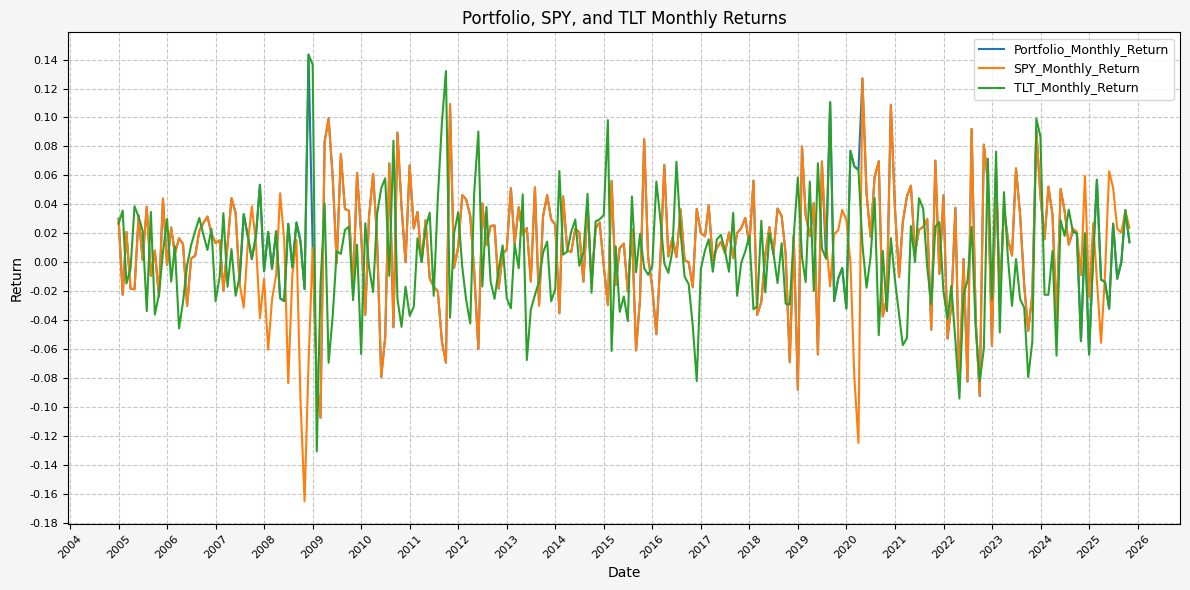

In [56]:
plot_timeseries(
    price_df=portfolio_monthly,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Portfolio_Monthly_Return", "SPY_Monthly_Return", "TLT_Monthly_Return"],
    title="Portfolio, SPY, and TLT Monthly Returns",
    x_label="Date",
    x_format="Year",
    y_label="Return",
    y_format="Decimal",
    y_format_decimal_places=2,
    y_tick_spacing=0.02,
    grid=True,
    legend=True,
    export_plot=True,
    plot_file_name="05_Monthly_Returns",
)

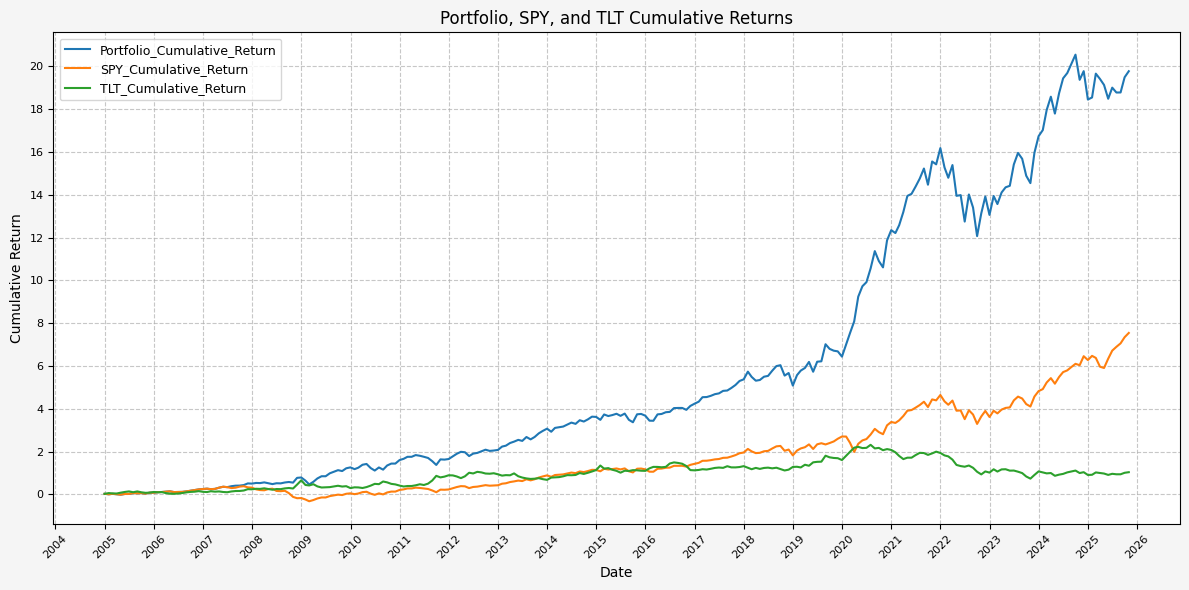

In [57]:
plot_timeseries(
    price_df=portfolio_monthly,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Portfolio_Cumulative_Return", "SPY_Cumulative_Return", "TLT_Cumulative_Return"],
    title="Portfolio, SPY, and TLT Cumulative Returns",
    x_label="Date",
    x_format="Year",
    y_label="Cumulative Return",
    y_format="Decimal",
    y_format_decimal_places=0,
    y_tick_spacing=2,
    grid=True,
    legend=True,
    export_plot=True,
    plot_file_name="05_Cumulative_Returns",
)

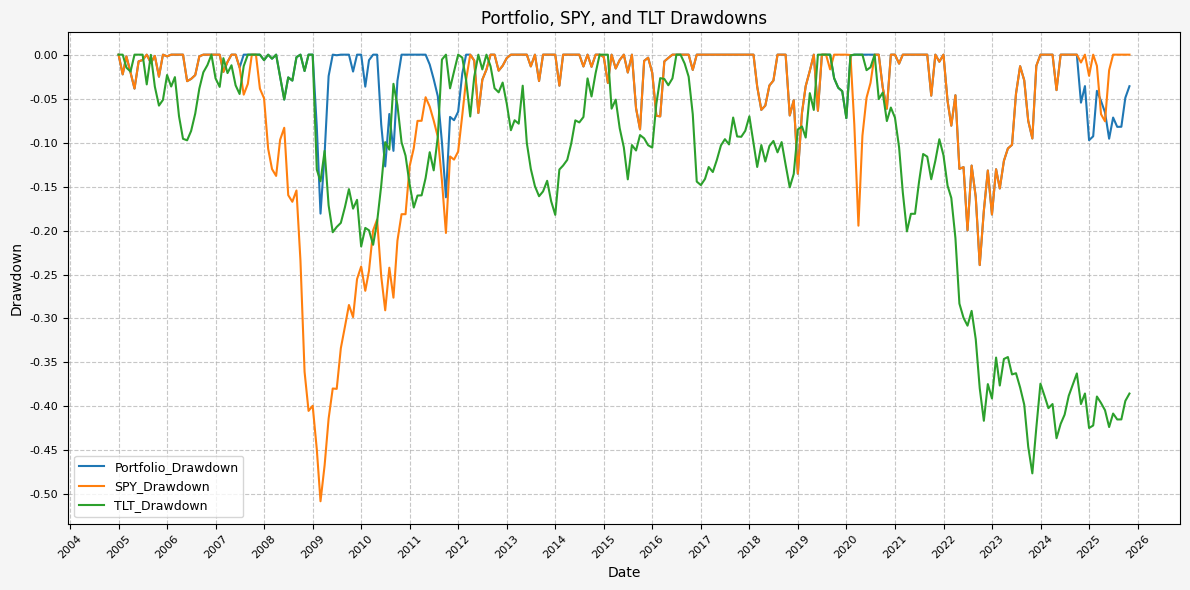

In [58]:
plot_timeseries(
    price_df=portfolio_monthly,
    plot_start_date=start_date,
    plot_end_date=end_date,
    plot_columns=["Portfolio_Drawdown", "SPY_Drawdown", "TLT_Drawdown"],
    title="Portfolio, SPY, and TLT Drawdowns",
    x_label="Date",
    x_format="Year",
    y_label="Drawdown",
    y_format="Decimal",
    y_format_decimal_places=2,
    y_tick_spacing=0.05,
    grid=True,
    legend=True,
    export_plot=True,
    plot_file_name="05_Drawdowns",
)

In [59]:
port_sum_stats = summary_stats(
    fund_list=["Portfolio", "SPY", "TLT"],
    df=portfolio_monthly[["Portfolio_Monthly_Return"]],
    period="Monthly",
    use_calendar_days=False,
    excel_export=False,
    pickle_export=False,
    output_confirmation=False,
)

spy_sum_stats = summary_stats(
    fund_list=["Portfolio", "SPY", "TLT"],
    df=portfolio_monthly[["SPY_Monthly_Return"]],
    period="Monthly",
    use_calendar_days=False,
    excel_export=False,
    pickle_export=False,
    output_confirmation=False,
)

tlt_sum_stats = summary_stats(
    fund_list=["Portfolio", "SPY", "TLT"],
    df=portfolio_monthly[["TLT_Monthly_Return"]],
    period="Monthly",
    use_calendar_days=False,
    excel_export=False,
    pickle_export=False,
    output_confirmation=False,
)

sum_stats = port_sum_stats.combine_first(spy_sum_stats).combine_first(tlt_sum_stats)

In [60]:
# Copy this <!-- INSERT_05_Portfolio_Stats_DF_HERE --> to index_temp.md
export_track_md_deps(dep_file=dep_file, md_filename="05_Portfolio_Stats_DF.md", content=sum_stats.to_markdown(floatfmt=".3f"))

✅ Exported and tracked: 05_Portfolio_Stats_DF.md
